## MCMC Sampling

This notebook performs a posterior analysis of cosmological parameters using MCMC sampling:

1. Load power spectrum from ELG_LOPnotqso and covariance matrices from EZmocks.
2. Run MCMC chains to explore the posterior distributions.
3. Visualize the posterior distributions and compare them to true values.

The focus is on examining the resulting posterior distributions and evaluating their consistency with expected cosmological values.


In [7]:
import os
import glob
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from getdist import plots

# from mockfactory import Catalog
from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import FOLPSTracerPowerSpectrumMultipoles, FOLPSRCTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.samplers.emcee import EmceeSampler
from desilike.samples import plotting, Chain
from desilike import setup_logging
setup_logging()  # for logging messages

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [9]:
# vairables for pk calculation
No = 0
zmin = 0.8  # low_z[0.8,1.1], high_z:[1.1, 1.6]
zmax = 1.1   
zeff = 0.95 # low_zeff:0.98, high_zeff:1.325
tracer = "ELG_LOPnotqso" 
ran_mock_num = "10" # ELG:10; LRG:8; QSO:4
region = "NGC"  # NGC or SGC

mocks_fn = os.path.join(os.environ['SCRATCH'], f"./altml{No}/mock{No}/")
pk_dir = os.path.join(os.environ['SCRATCH'], f"altml{No}/data{No}/pk/")
# pk_dir = os.path.join(os.environ['HOME'], "project_rc/main/data/pk/")
output_dir = '/global/homes/s/shengyu/project_rc/main/results'
cov_dir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/'

# load the pk file, the pk calculated from the pkrun.py
pk_fn = pk_dir+f'pkpoles_{tracer}_{region}_{zmin}_{zmax}_default_FKP_lin_thetacut0.05.npy'
wmatrix_fn = pk_dir+f'wmatrix_smooth_{tracer}_{region}_{zmin}_{zmax}_default_FKP_lin_thetacut0.05.npy'

# load the covariance matrix from the Ezmocks
cov_fns = []
cov_fn = f'pkpoles_ELG_LOP_{region}_z{zmin}-{zmax}_default_FKP_lin_nran10_cellsize6_boxsize9000.npy'
for i in range(100, 200):
    mock_dir = f'mock{i}/pk/'
    cov_fns.extend(glob.glob(os.path.join(cov_dir,  mock_dir, cov_fn), recursive=True))

In [10]:
# set the k bins
kmin     = 0.020
kmax     = 0.205
binning  = 0.005
k_ev     = np.arange(kmin, kmax, binning)
klen     = len(k_ev)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}

cosmology = 'LCDM' #LCDM, nuCDM, wCDM
theory_model = 'FOLPS'  # TNS, FOLPS, FOLPSRC

In [13]:
# MCMC sampling
nwalkers = 120 
interations = 2101 # save every 300 iterations

emulator_fn = f'./results/emulators/emulator_{cosmology}_z{zeff}_{theory_model}.npy'
chain_fn = f'./results/samples/{cosmology}/chain_{tracer}_{region}_z{zeff}.npy'

if os.path.exists(chain_fn):
    os.remove(chain_fn)
if not os.path.exists(chain_fn):
    if theory_model == 'FOLPS':
        theory_el = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
    if theory_model == 'FOLPSRC':
        theory_el = FOLPSRCTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))  
    observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                        klim=klim, 
                                                        covariance = cov_fns,
                                                        theory = theory_el,
                                                        kin=np.arange(0.001, 0.35, 0.002),
                                                        wmatrix=wmatrix_fn)                    
    likelihood = ObservablesGaussianLikelihood(observable)
    likelihood()
    sampler = EmceeSampler(likelihood, seed=42, nwalkers=nwalkers, save_fn =chain_fn)
    sampler.run(check={'max_eigen_gr': 0.05}, max_iterations = interations) # save every 300 iterations
    print("Sampling finished")

[000133.59] [0/1] 10-22 20:22  Emulator                  INFO     Loading ./results/emulators/emulator_LCDM_z0.95_FOLPS.npy.
[000134.33] [0/1] 10-22 20:22  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/altml0/data0/pk/pkpoles_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy'].
[000134.44] [0/1] 10-22 20:22  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock120/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock140/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdi

[000255.35] [0/1] 10-22 20:24  Chain                     INFO     Loading ./results/samples/LCDM/chain_ELG_LOPnotqso_NGC_z0.95.npy.


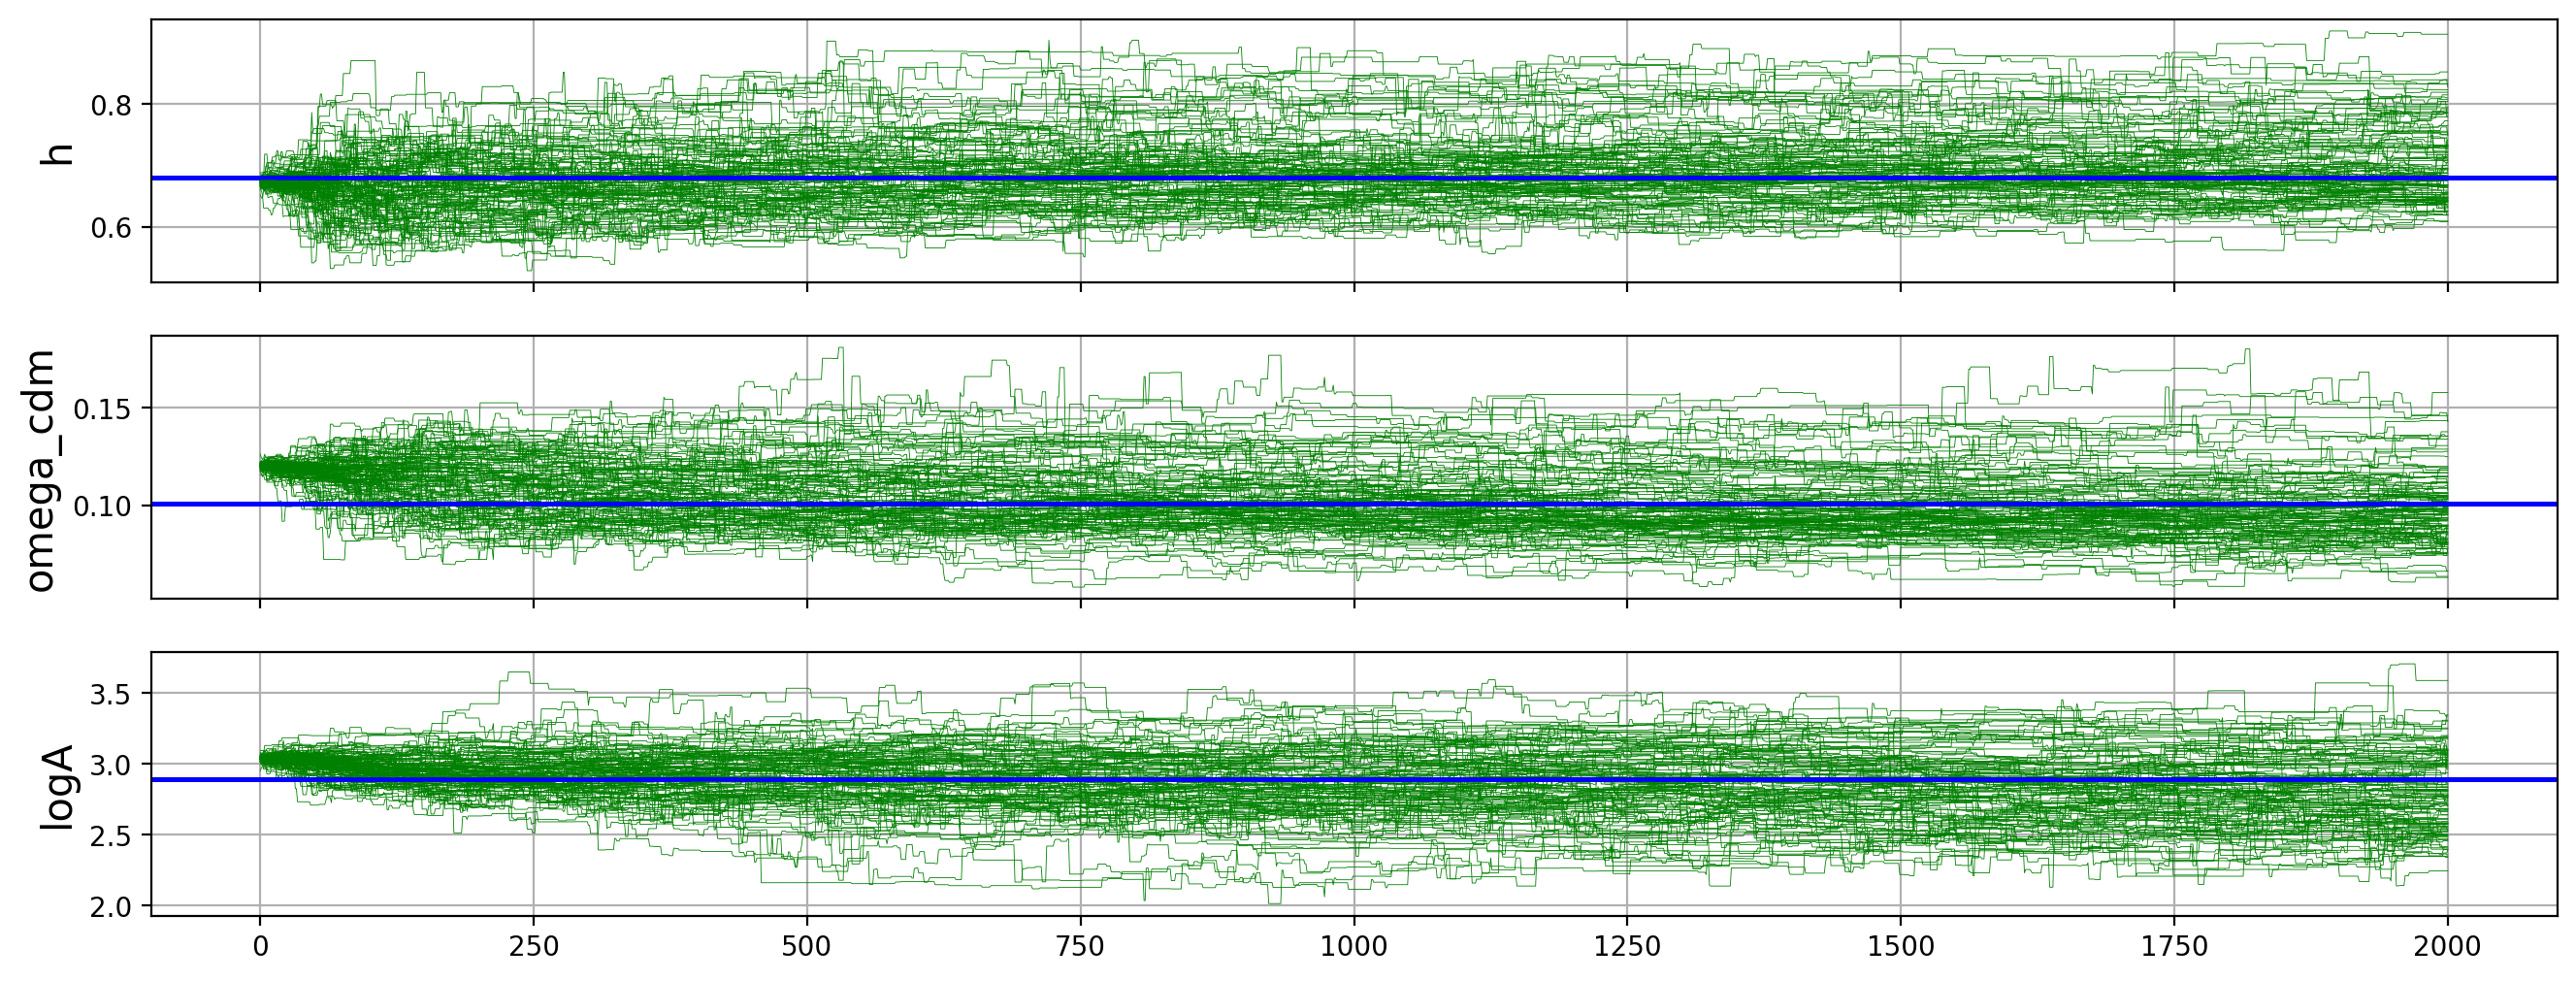

In [14]:
def set_true_values(params, catalogue='fiducial'):
    # true values for the QUIJOTE simulation (not true for the Abacus)
    update_values = {
        'fiducial': {'h':0.6736, 'omega_cdm': 0.1200, 'Omega_cdm': 0.2685, 'omega_b':0.02207,'logA': 3.0364, 'm_ncdm': 0.0, 'n_s':0.9624, 'w0_fld':-1.0, 'fc':0.01},
    }
    if catalogue in update_values:
        truth_values = update_values[catalogue]
    return [truth_values[param] for param in params if param in truth_values]

params= ['h', 'omega_cdm', 'logA']
ndim            = len(params)
chain = Chain.load(chain_fn).remove_burnin()[::]
chain_samples   = dict(zip(chain.basenames(), chain.data))
samples         = np.array([chain_samples[p] for p in params])
medians         = np.array(chain.median(params=params))
# true_values     = set_true_values(params)

fig, ax = plt.subplots(ndim, sharex=True, figsize=(16, 2 * ndim))
for i in range(nwalkers):
    for j in range(ndim):
        ax[j].plot(samples[j, :, i], c = 'green', lw=0.3)
        ax[j].set_ylabel(params[j], fontsize=15)
        ax[j].grid(True)
        ax[j].axhline(medians[j], c='blue', lw=1.2)
        # ax[j].axhline(true_values[j], c='red', lw=1.2)
        

[000271.22] [0/1] 10-22 20:24  Chain                     INFO     Loading ./results/samples/LCDM/chain_ELG_LOPnotqso_NGC_z0.95.npy.
Removed no burn in


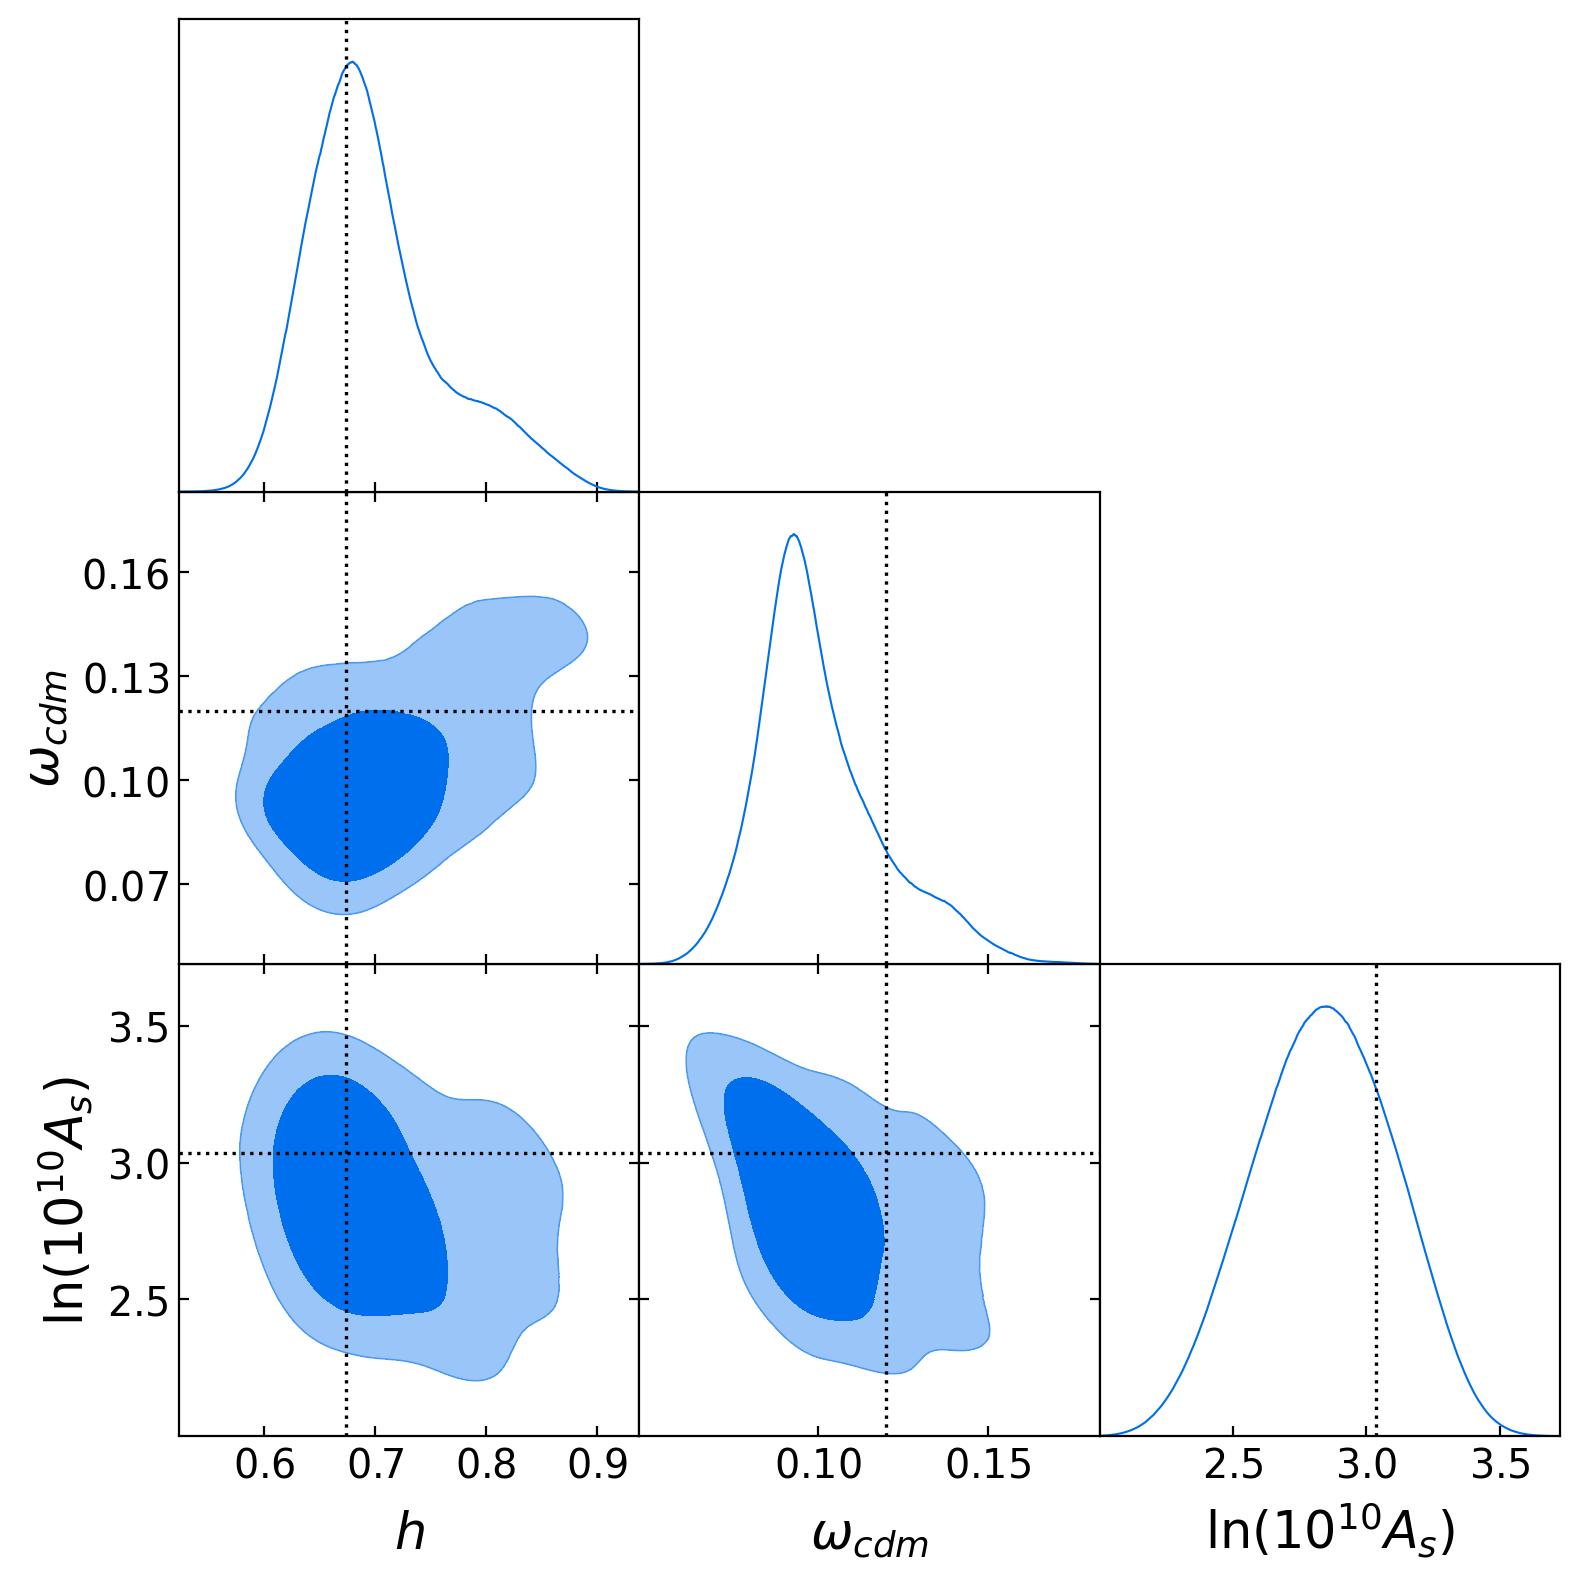

In [15]:
# plot the corner plot for posterior distributions
burnin      = 0.50
slice_step  = 200
params = ['h','omega_cdm','logA']
chain = Chain.load(chain_fn).remove_burnin(burnin)[::slice_step]

g = plots.get_subplot_plotter()
g.settings.fig_width_inch= 8
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.settings.axes_fontsize = 16
g.settings.figure_legend_frame = False

plotting.plot_triangle(chain, title_limit=0, filled = True, params = params,
                        #    legend_labels = [r'$FOLPS+f_c$', r'$FOLPS$'], legend_loc= 'upper right',

                            # contour_ls = lss, contour_lws = lws, contour_colors = colors, 
                            # param_limits=param_limits, 
                            smoothed=True, show=False, g=g)
true_values     = set_true_values(params)
for i in range(len(true_values)):
    for j in range(i+1):
        g.subplots[i,j].axvline(true_values[j], c = 'k', ls = ':', lw = 1.2)
        if i != j:
            g.subplots[i,j].axhline(true_values[i], c = 'k', ls = ':', lw = 1.2)